In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from pandas import read_csv
from matplotlib import pyplot
import itertools
import pandas as pd
pd.set_option('use_inf_as_na', True)
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

from sklearn.cluster import KMeans
# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

#visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# consistent plot size
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# handle unwanted warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

# time series related imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv("/Users/manju/Downloads/Chicago_Crime_2013_2015.csv",encoding='latin1')


data.shape


(697017, 22)

In [3]:
data.head(5)

,ï..ID,Case.Number,Date,Block,IUCR,Primary.Type,Description,Location.Description,Arrest,Domestic,...,Ward,Community.Area,FBI.Code,X.Coordinate,Y.Coordinate,Year,Updated.On,Latitude,Longitude,Location
0,10124853,HY313560,06/23/2015 11:50:00 PM,024XX S KEDVALE AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,...,22.0,30.0,06,1149248.0,1887712.0,2015,06/30/2015 12:40:42 PM,41.847805,-87.727747,"(41.84780493, -87.727747291)"
1,10124960,HY313663,06/23/2015 11:45:00 PM,051XX S WENTWORTH AVE,0454,BATTERY,AGG PO HANDS NO/MIN INJURY,POLICE FACILITY/VEH PARKING LOT,True,False,...,3.0,37.0,08B,1175865.0,1871146.0,2015,06/30/2015 12:40:42 PM,41.801790,-87.630560,"(41.801789811, -87.630559815)"
2,10124917,HY313603,06/23/2015 11:42:00 PM,049XX W RACE AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,APARTMENT,True,False,...,37.0,25.0,15,1143419.0,1903252.0,2015,06/30/2015 12:40:42 PM,41.890559,-87.748752,"(41.890559483, -87.748751767)"
3,10124869,HY313604,06/23/2015 11:42:00 PM,049XX W RACE AVE,2027,NARCOTICS,POSS: CRACK,APARTMENT,True,False,...,37.0,25.0,18,1143419.0,1903252.0,2015,06/30/2015 12:40:42 PM,41.890559,-87.748752,"(41.890559483, -87.748751767)"
4,10124873,HY313566,06/23/2015 11:40:00 PM,070XX S STATE ST,0496,BATTERY,AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST,SIDEWALK,False,True,...,6.0,69.0,04B,1177469.0,1858544.0,2015,06/30/2015 12:40:42 PM,41.767173,-87.625058,"(41.767172506, -87.625058064)"


In [3]:
data["Date"] = pd.to_datetime(data["Date"]).dt.date
data=data.groupby(['Date','Community.Area'])['Primary.Type'].agg('count').reset_index()
data.set_index("Date", inplace = True)

In [4]:
data.head(5)

,Community.Area,Primary.Type
Date,,
2013-01-01,1.0,18
2013-01-01,2.0,16
2013-01-01,3.0,15
2013-01-01,4.0,6
2013-01-01,5.0,3


In [5]:
maxdate=max(data.index)
new_df = pd.DataFrame()
for id_val, obs_period in data.groupby(["Community.Area"]):
    date_range = pd.date_range(min(obs_period.index), maxdate,freq="D")
    obs_period = obs_period.reindex(date_range, fill_value=pd.NA)
    obs_period["Community.Area"] = id_val
    if pd.isna(obs_period.at[obs_period.index[0], "Primary.Type"]):
        obs_period.at[obs_period.index[0], "Primary.Type"] = 0  # adding 0 at the beginning of the period if undefined
    obs_period= obs_period.fillna(0)      # filling Amount with last value
    new_df = pd.concat([new_df, obs_period])

data=new_df


In [9]:
data["Date"]=data.index
data['Date'] = pd.to_datetime(data['Date'])
data=data.reset_index(drop=True)
data = data.set_index('Date').groupby('Community.Area').resample('W-Mon').agg({'Primary.Type':'sum'}).reset_index()
data=data.set_index('Date')

In [13]:
test.head()

,community_id,Primary.Type
Date,,
2015-03-02,0.0,0.0
2015-03-09,0.0,0.0
2015-03-16,0.0,0.0
2015-03-23,0.0,0.0
2015-03-30,0.0,0.0


In [11]:
data= data.rename({'Community.Area': 'community_id'}, axis=1)
train=data.query('Date<="2015-02-28"')
test=data.query('Date>="2015-02-28"') 
test=test.query('Date<="2015-03-31"')

<AxesSubplot:title={'center':'Crimes'}, xlabel='Community', ylabel='Total Crimes'>

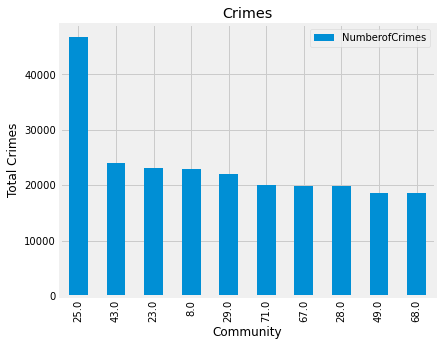

In [14]:
dfg = data.groupby('community_id')['Primary.Type'].agg(['sum'])
dfg['sum'] = dfg['sum'].astype(float)
dfg= dfg.rename({'sum': 'NumberofCrimes'}, axis=1)
dfg=dfg.nlargest(10,'NumberofCrimes',keep='first')
dfg.plot(kind='bar', title='Crimes', ylabel='Total Crimes',
         xlabel='Community', figsize=(6, 5))

In [15]:
seasonality=data
seasonality=seasonality.reset_index()
seasonality = seasonality.groupby('Date')['Primary.Type'].sum().reset_index()


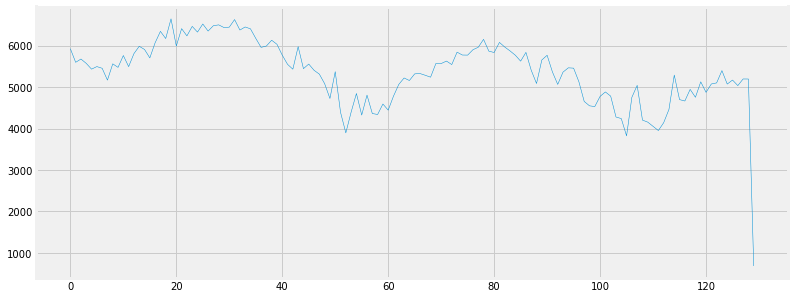

In [16]:
seasonality['Primary.Type'].plot(linewidth=0.5);

In [17]:
seasonality.to_csv("check.csv")

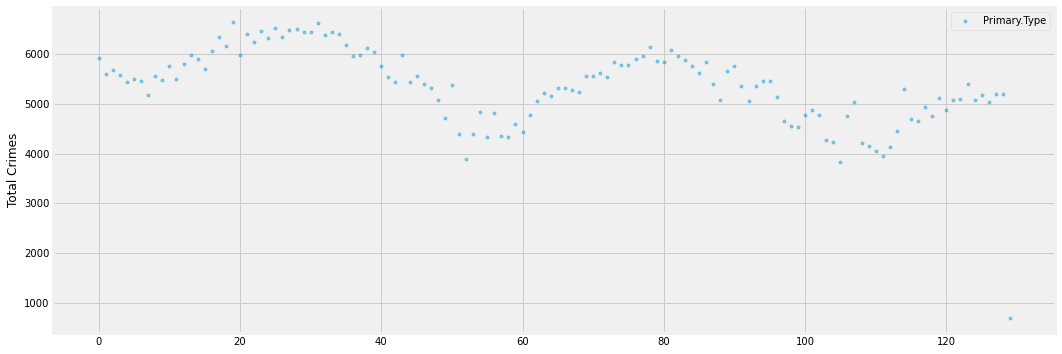

In [18]:
# Use seaborn style defaults and set the default figure size
# sns.set(rc={'figure.figsize':(18, 6)})

cols_plot = ['Primary.Type']

axes      = seasonality[cols_plot].plot(marker='.',
                                       alpha=0.4, 
                                       linestyle='None', 
                                       figsize=(16, 6), 
                                       subplots=True)

for ax in axes:
    ax.set_ylabel('Total Crimes')

In [19]:
params = {
 0:[(1,1,1), (0,0,0,0)],
 1:[(1,1,0), (0,0,0,0)],
 2:[(1,1,0), (0,0,0,0)],
 3:[(1,1,0), (0,0,0,0)],
 4:[(1,1,1), (0,0,0,0)],
 5:[(1,1,1), (0,0,0,0)],
 6:[(1,1,2), (0,0,0,0)],
 7:[(1,1,1), (0,0,0,0)],
 8:[(1,1,1), (0,0,0,0)],
 9:[(1,1,0), (0,0,0,0)],
 10:[(2,1,1), (0,0,0,0)],
11:[(2,1,1), (0,0,0,0)],
12:[(2,1,1), (0,0,0,0)],
13:[(1,1,2), (0,0,0,0)],
14:[(1,1,2), (0,0,0,0)],
15:[(0,1,1), (0,0,0,0)]
}

In [20]:
steps=5

community_id=[i for i in train['community_id'].unique()]


In [21]:
def sarimax_gridsearch(ts,community_id,params, maxiter=5000):
    '''
    Input: 
        ts : your time series data
        col : community area on which the model is being built
        maxiter : number of iterations, increase if your model isn't converging
                
    Return:
        Print and save out top parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''
# Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    ans = []
    for i in range(0,len(params)):
        
        mod = SARIMAX(ts,
                      order=params[i][0],
                      seasonal_order=params[i][1],
                      enforce_stationarity=False,
                      enforce_invertibility=False
                     )
 
        output = mod.fit()
        ans.append([community_id,params[i][0][0],params[i][0][1],params[i][0][2], params[i][1][0],params[i][1][1],params[i][1][2],params[i][1][3],params[i][0],params[i][1], output.aic])
        print('SARIMAX {} 12 : parameters {},{} AIC={} '.format(community_id,params[i][0], params[i][1], output.aic))
# Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['community_id','p','d','q', 'Ps','Ds','Qs','Ss','pdq','pdqs', 'aic'])
# Sort and return top  combination
    ans_df = ans_df.sort_values(by=['community_id','aic'],ascending=True)[0:1]
    
    return ans_df

In [22]:
best_param=pd.DataFrame() # --- Dataframe to store the best parameters for each area-product combination
prediction=pd.DataFrame() # -- Dataframe to store the predictins for next 16 months for each area-product combination
ans = []
par={} 
for t in community_id:
    data=train[train['community_id']==t]
    
    forecast=pd.DataFrame()
    temp={}
# STEP 1 - Calling function to get best paramaters for each area-product combination
    
    df_ans=sarimax_gridsearch(data['Primary.Type'],t,params)
# STEP 2 - Storing the best parameters for each area-product combination
    best_param=best_param.append(df_ans)
    best_param=best_param.sort_values(by=['community_id','aic'],ascending=True)
    print('for product {}'.format(t))
    print('best pdq is {}'.format(best_param.loc[(best_param['community_id']==t) ]['pdq'].iloc[0]))
    print('best pdqs is {}'.format(best_param.loc[(best_param['community_id']==t)]['pdqs'].iloc[0]))
    
 # STEP 3- Building model with best parameters to make forecast for next 5 Weeks   
    smx = SARIMAX(
            data['Primary.Type'],
            order=best_param.loc[(best_param['community_id']==t)]['pdq'].iloc[0],
            seasonal_order=best_param.loc[(best_param['community_id']==t)]['pdqs'].iloc[0],
            enforce_stationarity=False,
            enforce_invertibility=False
          )
    model = smx.fit()
    predictions = model.get_forecast(
      steps=steps
    ).predicted_mean
    df_forecast = pd.DataFrame(predictions)
    df_forecast.columns=['Primary.Type']
    temp['Primary.Type']=(best_param.loc[(best_param['community_id']==t)]['pdq'].iloc[0],best_param.loc[(best_param['community_id']==t)]['pdqs'].iloc[0])
    forecast=pd.concat([forecast, df_forecast], axis=1)
    forecast=forecast.fillna(0)
    forecast['community_id']=t
    par[t]=temp # -- storing the best parameters into dictionary . this is an optional step
  

    prediction=pd.concat([prediction,forecast],axis=0)

/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


SARIMAX 0.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=-8.96658553032553 
SARIMAX 0.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=32.46380679670341 
SARIMAX 0.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=32.46380679670341 
SARIMAX 0.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=32.46380679670341 
SARIMAX 0.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=-8.96658553032553 
SARIMAX 0.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=-8.96658553032553 
SARIMAX 0.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=-7.550924428476634 
SARIMAX 0.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=-8.96658553032553 
SARIMAX 0.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=-8.96658553032553 
SARIMAX 0.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=32.46380679670341 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 0.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=-6.62748275741559 
SARIMAX 0.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=-6.62748275741559 
SARIMAX 0.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=-6.62748275741559 
SARIMAX 0.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=-7.550924428476634 
SARIMAX 0.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=-7.550924428476634 
SARIMAX 0.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=-10.604664788370293 
for product 0.0
best pdq is (0, 1, 1)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 1.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=829.3600474047713 
SARIMAX 1.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=849.4870832926132 
SARIMAX 1.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=849.4870832926132 
SARIMAX 1.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=849.4870832926132 
SARIMAX 1.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=829.3600474047713 
SARIMAX 1.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=829.3600474047713 
SARIMAX 1.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=823.7010068514047 
SARIMAX 1.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=829.3600474047713 
SARIMAX 1.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=829.3600474047713 
SARIMAX 1.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=849.4870832926132 
SARIMAX 1.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=830.9110835783986 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 1.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=830.9110835783986 
SARIMAX 1.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=830.9110835783986 
SARIMAX 1.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=823.7010068514047 
SARIMAX 1.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=823.7010068514047 
SARIMAX 1.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=831.0740977159296 
for product 1.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 2.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=824.1214932186233 
SARIMAX 2.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=841.4957599127023 
SARIMAX 2.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=841.4957599127023 
SARIMAX 2.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=841.4957599127023 
SARIMAX 2.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=824.1214932186233 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 2.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=824.1214932186233 
SARIMAX 2.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=818.2268727547101 
SARIMAX 2.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=824.1214932186233 
SARIMAX 2.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=824.1214932186233 
SARIMAX 2.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=841.4957599127023 
SARIMAX 2.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=826.1201328772152 
SARIMAX 2.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=826.1201328772152 
SARIMAX 2.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=826.1201328772152 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 2.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=818.2268727547101 
SARIMAX 2.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=818.2268727547101 
SARIMAX 2.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=825.1977252611752 
for product 2.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 3.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=872.9292077094823 
SARIMAX 3.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=895.2148559433379 
SARIMAX 3.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=895.2148559433379 
SARIMAX 3.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=895.2148559433379 
SARIMAX 3.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=872.9292077094823 
SARIMAX 3.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=872.9292077094823 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 3.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=867.5962785169964 
SARIMAX 3.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=872.9292077094823 
SARIMAX 3.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=872.9292077094823 
SARIMAX 3.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=895.2148559433379 
SARIMAX 3.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=874.056478832145 
SARIMAX 3.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=874.056478832145 
SARIMAX 3.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=874.056478832145 
SARIMAX 3.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=867.5962785169964 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 3.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=867.5962785169964 
SARIMAX 3.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=871.7012214797238 
for product 3.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 4.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=756.8043356679079 
SARIMAX 4.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=788.0509321889862 
SARIMAX 4.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=788.0509321889862 
SARIMAX 4.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=788.0509321889862 
SARIMAX 4.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=756.8043356679079 
SARIMAX 4.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=756.8043356679079 
SARIMAX 4.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=751.8363295199898 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 4.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=756.8043356679079 
SARIMAX 4.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=756.8043356679079 
SARIMAX 4.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=788.0509321889862 
SARIMAX 4.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=758.8034769488295 
SARIMAX 4.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=758.8034769488295 
SARIMAX 4.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=758.8034769488295 
SARIMAX 4.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=751.8363295199898 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 4.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=751.8363295199898 
SARIMAX 4.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=754.8485457163471 
for product 4.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 5.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=771.3381106328902 
SARIMAX 5.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=809.3943286407643 
SARIMAX 5.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=809.3943286407643 
SARIMAX 5.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=809.3943286407643 
SARIMAX 5.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=771.3381106328902 
SARIMAX 5.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=771.3381106328902 
SARIMAX 5.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=766.9020221236599 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 5.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=771.3381106328902 
SARIMAX 5.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=771.3381106328902 
SARIMAX 5.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=809.3943286407643 
SARIMAX 5.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=773.3381105748838 
SARIMAX 5.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=773.3381105748838 
SARIMAX 5.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=773.3381105748838 
SARIMAX 5.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=766.9020221236599 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 5.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=766.9020221236599 
SARIMAX 5.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=769.7965427231503 
for product 5.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 6.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=955.7372980836284 
SARIMAX 6.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=973.1410391564234 
SARIMAX 6.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=973.1410391564234 
SARIMAX 6.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=973.1410391564234 
SARIMAX 6.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=955.7372980836284 
SARIMAX 6.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=955.7372980836284 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 6.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=941.5705685221972 
SARIMAX 6.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=955.7372980836284 
SARIMAX 6.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=955.7372980836284 
SARIMAX 6.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=973.1410391564234 
SARIMAX 6.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=956.5120925547677 
SARIMAX 6.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=956.5120925547677 
SARIMAX 6.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=956.5120925547677 
SARIMAX 6.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=941.5705685221972 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 6.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=941.5705685221972 
SARIMAX 6.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=954.6697517959319 
for product 6.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 7.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=893.4881615754617 
SARIMAX 7.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=908.5144539603403 
SARIMAX 7.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=908.5144539603403 
SARIMAX 7.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=908.5144539603403 
SARIMAX 7.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=893.4881615754617 
SARIMAX 7.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=893.4881615754617 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 7.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=884.4245423232712 
SARIMAX 7.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=893.4881615754617 
SARIMAX 7.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=893.4881615754617 
SARIMAX 7.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=908.5144539603403 
SARIMAX 7.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=894.4166737149397 
SARIMAX 7.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=894.4166737149397 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 7.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=894.4166737149397 
SARIMAX 7.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=884.4245423232712 
SARIMAX 7.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=884.4245423232712 
SARIMAX 7.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=892.3103773220793 
for product 7.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 8.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=959.4863952988694 
SARIMAX 8.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=985.642298605916 
SARIMAX 8.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=985.642298605916 
SARIMAX 8.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=985.642298605916 
SARIMAX 8.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=959.4863952988694 
SARIMAX 8.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=959.4863952988694 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 8.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=952.8177405575644 
SARIMAX 8.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=959.4863952988694 
SARIMAX 8.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=959.4863952988694 
SARIMAX 8.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=985.642298605916 
SARIMAX 8.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=959.4346224188597 
SARIMAX 8.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=959.4346224188597 
SARIMAX 8.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=959.4346224188597 
SARIMAX 8.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=952.8177405575644 
SARIMAX 8.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=952.8177405575644 
SARIMAX 8.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=957.8405987214472 
for product 8.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 9.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=486.43284686952944 
SARIMAX 9.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=528.2439675817163 
SARIMAX 9.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=528.2439675817163 
SARIMAX 9.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=528.2439675817163 
SARIMAX 9.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=486.43284686952944 
SARIMAX 9.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=486.43284686952944 
SARIMAX 9.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=477.11774503006905 
SARIMAX 9.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=486.43284686952944 
SARIMAX 9.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=486.43284686952944 
SARIMAX 9.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=528.2439675817163 
SARIMAX 9.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=477.26513131801795 
SARIMAX 9.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=477.26513131801795 
SARIMAX 9.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=477.26513131801795 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 9.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=477.11774503006905 
SARIMAX 9.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=477.11774503006905 
SARIMAX 9.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=484.49555504243096 
for product 9.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 10.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=716.3283508698044 
SARIMAX 10.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=742.3386452800571 
SARIMAX 10.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=742.3386452800571 
SARIMAX 10.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=742.3386452800571 
SARIMAX 10.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=716.3283508698044 
SARIMAX 10.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=716.3283508698044 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 10.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=711.0605265745033 
SARIMAX 10.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=716.3283508698044 
SARIMAX 10.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=716.3283508698044 
SARIMAX 10.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=742.3386452800571 
SARIMAX 10.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=715.2864679007735 
SARIMAX 10.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=715.2864679007735 
SARIMAX 10.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=715.2864679007735 
SARIMAX 10.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=711.0605265745033 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 10.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=711.0605265745033 
SARIMAX 10.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=715.5047879658114 
for product 10.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 11.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=706.6394462596603 
SARIMAX 11.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=748.9823508625096 
SARIMAX 11.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=748.9823508625096 
SARIMAX 11.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=748.9823508625096 
SARIMAX 11.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=706.6394462596603 
SARIMAX 11.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=706.6394462596603 
SARIMAX 11.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=700.7093704186049 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 11.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=706.6394462596603 
SARIMAX 11.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=706.6394462596603 
SARIMAX 11.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=748.9823508625096 
SARIMAX 11.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=708.6392606684285 
SARIMAX 11.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=708.6392606684285 
SARIMAX 11.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=708.6392606684285 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 11.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=700.7093704186049 
SARIMAX 11.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=700.7093704186049 
SARIMAX 11.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=705.536536876787 
for product 11.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 12.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=588.4101716633165 
SARIMAX 12.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=622.4374759630427 
SARIMAX 12.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=622.4374759630427 
SARIMAX 12.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=622.4374759630427 
SARIMAX 12.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=588.4101716633165 
SARIMAX 12.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=588.4101716633165 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 12.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=585.6752316286543 
SARIMAX 12.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=588.4101716633165 
SARIMAX 12.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=588.4101716633165 
SARIMAX 12.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=622.4374759630427 
SARIMAX 12.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=589.8552152134939 
SARIMAX 12.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=589.8552152134939 
SARIMAX 12.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=589.8552152134939 
SARIMAX 12.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=585.6752316286543 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 12.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=585.6752316286543 
SARIMAX 12.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=586.410811732219 
for product 12.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 13.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=631.9410436613484 
SARIMAX 13.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=668.3667176732126 
SARIMAX 13.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=668.3667176732126 
SARIMAX 13.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=668.3667176732126 
SARIMAX 13.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=631.9410436613484 
SARIMAX 13.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=631.9410436613484 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 13.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=627.1546924258622 
SARIMAX 13.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=631.9410436613484 
SARIMAX 13.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=631.9410436613484 
SARIMAX 13.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=668.3667176732126 
SARIMAX 13.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=633.9406046809946 
SARIMAX 13.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=633.9406046809946 
SARIMAX 13.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=633.9406046809946 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 13.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=627.1546924258622 
SARIMAX 13.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=627.1546924258622 
SARIMAX 13.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=635.55521696558 
for product 13.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 14.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=774.7895055283275 
SARIMAX 14.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=802.3623474255198 
SARIMAX 14.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=802.3623474255198 
SARIMAX 14.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=802.3623474255198 
SARIMAX 14.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=774.7895055283275 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 14.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=774.7895055283275 
SARIMAX 14.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=769.9098976900683 
SARIMAX 14.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=774.7895055283275 
SARIMAX 14.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=774.7895055283275 
SARIMAX 14.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=802.3623474255198 
SARIMAX 14.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=776.8125940223248 
SARIMAX 14.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=776.8125940223248 
SARIMAX 14.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=776.8125940223248 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 14.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=769.9098976900683 
SARIMAX 14.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=769.9098976900683 
SARIMAX 14.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=772.904180802793 
for product 14.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 15.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=823.039042348582 
SARIMAX 15.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=860.2288239746212 
SARIMAX 15.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=860.2288239746212 
SARIMAX 15.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=860.2288239746212 
SARIMAX 15.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=823.039042348582 
SARIMAX 15.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=823.039042348582 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 15.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=818.0639017177637 
SARIMAX 15.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=823.039042348582 
SARIMAX 15.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=823.039042348582 
SARIMAX 15.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=860.2288239746212 
SARIMAX 15.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=824.4830251035031 
SARIMAX 15.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=824.4830251035031 
SARIMAX 15.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=824.4830251035031 
SARIMAX 15.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=818.0639017177637 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 15.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=818.0639017177637 
SARIMAX 15.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=821.4850561798992 
for product 15.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 16.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=818.5888327844336 
SARIMAX 16.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=838.0658796741428 
SARIMAX 16.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=838.0658796741428 
SARIMAX 16.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=838.0658796741428 
SARIMAX 16.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=818.5888327844336 
SARIMAX 16.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=818.5888327844336 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 16.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=813.6761581568124 
SARIMAX 16.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=818.5888327844336 
SARIMAX 16.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=818.5888327844336 
SARIMAX 16.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=838.0658796741428 
SARIMAX 16.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=819.9919921055016 
SARIMAX 16.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=819.9919921055016 
SARIMAX 16.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=819.9919921055016 
SARIMAX 16.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=813.6761581568124 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 16.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=813.6761581568124 
SARIMAX 16.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=816.591369232752 
for product 16.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 17.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=722.6592202130363 
SARIMAX 17.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=751.5284427502277 
SARIMAX 17.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=751.5284427502277 
SARIMAX 17.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=751.5284427502277 
SARIMAX 17.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=722.6592202130363 
SARIMAX 17.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=722.6592202130363 
SARIMAX 17.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=718.5125472141431 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 17.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=722.6592202130363 
SARIMAX 17.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=722.6592202130363 
SARIMAX 17.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=751.5284427502277 
SARIMAX 17.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=724.6580627197874 
SARIMAX 17.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=724.6580627197874 
SARIMAX 17.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=724.6580627197874 
SARIMAX 17.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=718.5125472141431 
SARIMAX 17.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=718.5125472141431 
SARIMAX 17.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=721.5064924051587 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

for product 17.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 18.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=580.3110046134799 
SARIMAX 18.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=616.4508457266257 
SARIMAX 18.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=616.4508457266257 
SARIMAX 18.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=616.4508457266257 
SARIMAX 18.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=580.3110046134799 
SARIMAX 18.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=580.3110046134799 
SARIMAX 18.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=574.3294070009383 
SARIMAX 18.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=580.3110046134799 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 18.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=580.3110046134799 
SARIMAX 18.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=616.4508457266257 
SARIMAX 18.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=581.9707234006823 
SARIMAX 18.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=581.9707234006823 
SARIMAX 18.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=581.9707234006823 
SARIMAX 18.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=574.3294070009383 
SARIMAX 18.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=574.3294070009383 
SARIMAX 18.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=578.6719267852303 
for product 18.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 19.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=874.3141621856047 
SARIMAX 19.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=904.5489555533824 
SARIMAX 19.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=904.5489555533824 
SARIMAX 19.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=904.5489555533824 
SARIMAX 19.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=874.3141621856047 
SARIMAX 19.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=874.3141621856047 
SARIMAX 19.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=866.0043283629676 
SARIMAX 19.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=874.3141621856047 
SARIMAX 19.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=874.3141621856047 
SARIMAX 19.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=904.5489555533824 
SARIMAX 19.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=873.1729109153949 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 19.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=873.1729109153949 
SARIMAX 19.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=873.1729109153949 
SARIMAX 19.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=866.0043283629676 
SARIMAX 19.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=866.0043283629676 
SARIMAX 19.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=873.1339705517763 
for product 19.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 20.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=748.7225235398496 
SARIMAX 20.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=785.3225952553149 
SARIMAX 20.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=785.3225952553149 
SARIMAX 20.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=785.3225952553149 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 20.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=748.7225235398496 
SARIMAX 20.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=748.7225235398496 
SARIMAX 20.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=741.7170085199364 
SARIMAX 20.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=748.7225235398496 
SARIMAX 20.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=748.7225235398496 
SARIMAX 20.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=785.3225952553149 
SARIMAX 20.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=747.4230336359946 
SARIMAX 20.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=747.4230336359946 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 20.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=747.4230336359946 
SARIMAX 20.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=741.7170085199364 
SARIMAX 20.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=741.7170085199364 
SARIMAX 20.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=748.4357751876381 
for product 20.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 21.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=757.1867371504537 
SARIMAX 21.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=779.7211665481053 
SARIMAX 21.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=779.7211665481053 
SARIMAX 21.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=779.7211665481053 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 21.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=757.1867371504537 
SARIMAX 21.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=757.1867371504537 
SARIMAX 21.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=752.8250728383495 
SARIMAX 21.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=757.1867371504537 
SARIMAX 21.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=757.1867371504537 
SARIMAX 21.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=779.7211665481053 
SARIMAX 21.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=757.9676773621349 
SARIMAX 21.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=757.9676773621349 
SARIMAX 21.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=757.9676773621349 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 21.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=752.8250728383495 
SARIMAX 21.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=752.8250728383495 
SARIMAX 21.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=755.9664951593821 
for product 21.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 22.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=877.2772571618252 
SARIMAX 22.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=903.1728593113133 
SARIMAX 22.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=903.1728593113133 
SARIMAX 22.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=903.1728593113133 
SARIMAX 22.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=877.2772571618252 
SARIMAX 22.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=877.2772571618252 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 22.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=870.6085130841456 
SARIMAX 22.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=877.2772571618252 
SARIMAX 22.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=877.2772571618252 
SARIMAX 22.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=903.1728593113133 
SARIMAX 22.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=878.9433858474291 
SARIMAX 22.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=878.9433858474291 
SARIMAX 22.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=878.9433858474291 
SARIMAX 22.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=870.6085130841456 
SARIMAX 22.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=870.6085130841456 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 22.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=875.828121787298 
for product 22.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 23.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=972.2266484113461 
SARIMAX 23.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=999.4091071156761 
SARIMAX 23.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=999.4091071156761 
SARIMAX 23.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=999.4091071156761 
SARIMAX 23.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=972.2266484113461 
SARIMAX 23.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=972.2266484113461 
SARIMAX 23.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=965.5595598564314 
SARIMAX 23.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=972.2266484113461 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 23.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=972.2266484113461 
SARIMAX 23.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=999.4091071156761 
SARIMAX 23.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=969.2135886082942 
SARIMAX 23.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=969.2135886082942 
SARIMAX 23.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=969.2135886082942 
SARIMAX 23.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=965.5595598564314 
SARIMAX 23.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=965.5595598564314 
SARIMAX 23.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=970.9068626938656 
for product 23.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 24.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=942.6233353110367 
SARIMAX 24.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=961.4007180271992 
SARIMAX 24.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=961.4007180271992 
SARIMAX 24.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=961.4007180271992 
SARIMAX 24.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=942.6233353110367 
SARIMAX 24.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=942.6233353110367 
SARIMAX 24.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=936.4192387686718 
SARIMAX 24.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=942.6233353110367 
SARIMAX 24.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=942.6233353110367 
SARIMAX 24.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=961.4007180271992 
SARIMAX 24.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=944.6085997323289 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 24.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=944.6085997323289 
SARIMAX 24.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=944.6085997323289 
SARIMAX 24.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=936.4192387686718 
SARIMAX 24.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=936.4192387686718 
SARIMAX 24.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=940.9189827915144 
for product 24.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 25.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=1050.1099650767153 
SARIMAX 25.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=1064.9124172798786 
SARIMAX 25.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=1064.9124172798786 
SARIMAX 25.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=1064.9124172798786 

/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s


SARIMAX 25.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=1050.1099650767153 
SARIMAX 25.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=1050.1099650767153 
SARIMAX 25.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=1038.6751871219851 
SARIMAX 25.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=1050.1099650767153 
SARIMAX 25.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=1050.1099650767153 
SARIMAX 25.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=1064.9124172798786 
SARIMAX 25.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=1052.0706109784899 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 25.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=1052.0706109784899 
SARIMAX 25.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=1052.0706109784899 
SARIMAX 25.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=1038.6751871219851 
SARIMAX 25.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=1038.6751871219851 
SARIMAX 25.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=1048.3102875109294 
for product 25.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 26.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=898.7761410950626 
SARIMAX 26.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=926.0474749829111 
SARIMAX 26.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=926.0474749829111 
SARIMAX 26.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=926.0474749829111 
SARIMAX 26.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=898.7761410950626 
SARIMAX 26.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=898.7761410950626 
SARIMAX 26.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=892.9066115740347 
SARIMAX 26.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=898.7761410950626 
SARIMAX 26.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=898.7761410950626 
SARIMAX 26.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=926.0474749829111 
SARIMAX 26.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=900.1454854797902 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 26.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=900.1454854797902 
SARIMAX 26.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=900.1454854797902 
SARIMAX 26.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=892.9066115740347 
SARIMAX 26.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=892.9066115740347 
SARIMAX 26.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=897.532757080505 
for product 26.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 27.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=891.6280444348697 
SARIMAX 27.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=906.8586734555689 
SARIMAX 27.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=906.8586734555689 
SARIMAX 27.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=906.8586734555689 

/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s


SARIMAX 27.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=891.6280444348697 
SARIMAX 27.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=891.6280444348697 
SARIMAX 27.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=885.6139530825023 
SARIMAX 27.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=891.6280444348697 
SARIMAX 27.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=891.6280444348697 
SARIMAX 27.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=906.8586734555689 
SARIMAX 27.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=893.6361380130717 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 27.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=893.6361380130717 
SARIMAX 27.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=893.6361380130717 
SARIMAX 27.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=885.6139530825023 
SARIMAX 27.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=885.6139530825023 
SARIMAX 27.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=891.8394493693703 
for product 27.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 28.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=961.5436175117853 
SARIMAX 28.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=978.7812555557877 
SARIMAX 28.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=978.7812555557877 
SARIMAX 28.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=978.7812555557877 
SARIMAX 28.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=961.5436175117853 
SARIMAX 28.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=961.5436175117853 
SARIMAX 28.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=953.0007412214339 
SARIMAX 28.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=961.5436175117853 
SARIMAX 28.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=961.5436175117853 
SARIMAX 28.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=978.7812555557877 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 28.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=963.5262743044796 
SARIMAX 28.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=963.5262743044796 
SARIMAX 28.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=963.5262743044796 
SARIMAX 28.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=953.0007412214339 
SARIMAX 28.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=953.0007412214339 
SARIMAX 28.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=959.9416039029985 
for product 28.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 29.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=947.1713898877026 
SARIMAX 29.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=961.411216690058 
SARIMAX 29.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=961.411216690058 
SARIMAX 29.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=961.411216690058 
SARIMAX 29.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=947.1713898877026 
SARIMAX 29.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=947.1713898877026 
SARIMAX 29.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=937.8823412980267 
SARIMAX 29.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=947.1713898877026 
SARIMAX 29.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=947.1713898877026 
SARIMAX 29.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=961.411216690058 
SARIMAX 29.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=949.1523887982842 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 29.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=949.1523887982842 
SARIMAX 29.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=949.1523887982842 
SARIMAX 29.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=937.8823412980267 
SARIMAX 29.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=937.8823412980267 
SARIMAX 29.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=945.4009821747134 
for product 29.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 30.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=870.4316869606245 
SARIMAX 30.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=895.7324399540801 
SARIMAX 30.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=895.7324399540801 
SARIMAX 30.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=895.7324399540801 
SARIMAX 30.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=870.4316869606245 
SARIMAX 30.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=870.4316869606245 
SARIMAX 30.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=864.7963052873303 
SARIMAX 30.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=870.4316869606245 
SARIMAX 30.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=870.4316869606245 
SARIMAX 30.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=895.7324399540801 
SARIMAX 30.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=870.2662989461166 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 30.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=870.2662989461166 
SARIMAX 30.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=870.2662989461166 
SARIMAX 30.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=864.7963052873303 
SARIMAX 30.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=864.7963052873303 
SARIMAX 30.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=868.4561054873876 
for product 30.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 31.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=797.3618845561987 
SARIMAX 31.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=823.3197890231073 
SARIMAX 31.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=823.3197890231073 

/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s


SARIMAX 31.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=823.3197890231073 
SARIMAX 31.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=797.3618845561987 
SARIMAX 31.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=797.3618845561987 
SARIMAX 31.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=792.973431987514 
SARIMAX 31.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=797.3618845561987 
SARIMAX 31.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=797.3618845561987 
SARIMAX 31.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=823.3197890231073 
SARIMAX 31.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=799.0293355985763 
SARIMAX 31.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=799.0293355985763 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 31.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=799.0293355985763 
SARIMAX 31.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=792.973431987514 
SARIMAX 31.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=792.973431987514 
SARIMAX 31.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=795.7673165045693 
for product 31.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 32.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=971.6324069371011 
SARIMAX 32.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=996.1207872443612 
SARIMAX 32.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=996.1207872443612 
SARIMAX 32.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=996.1207872443612 
SARIMAX 32.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=971.6324069371011 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 32.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=971.6324069371011 
SARIMAX 32.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=965.2871275020095 
SARIMAX 32.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=971.6324069371011 
SARIMAX 32.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=971.6324069371011 
SARIMAX 32.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=996.1207872443612 
SARIMAX 32.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=973.6324059308544 
SARIMAX 32.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=973.6324059308544 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 32.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=973.6324059308544 
SARIMAX 32.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=965.2871275020095 
SARIMAX 32.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=965.2871275020095 
SARIMAX 32.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=969.692065318164 
for product 32.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 33.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=778.5983923412201 
SARIMAX 33.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=810.6580743594606 
SARIMAX 33.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=810.6580743594606 
SARIMAX 33.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=810.6580743594606 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 33.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=778.5983923412201 
SARIMAX 33.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=778.5983923412201 
SARIMAX 33.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=771.9061801213849 
SARIMAX 33.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=778.5983923412201 
SARIMAX 33.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=778.5983923412201 
SARIMAX 33.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=810.6580743594606 
SARIMAX 33.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=780.5945653808755 
SARIMAX 33.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=780.5945653808755 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 33.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=780.5945653808755 
SARIMAX 33.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=771.9061801213849 
SARIMAX 33.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=771.9061801213849 
SARIMAX 33.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=776.6190536472685 
for product 33.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 34.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=701.1816388213792 
SARIMAX 34.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=737.0075175168054 
SARIMAX 34.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=737.0075175168054 
SARIMAX 34.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=737.0075175168054 
SARIMAX 34.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=701.1816388213792 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 34.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=701.1816388213792 
SARIMAX 34.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=695.6753939453757 
SARIMAX 34.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=701.1816388213792 
SARIMAX 34.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=701.1816388213792 
SARIMAX 34.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=737.0075175168054 
SARIMAX 34.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=701.3865202872987 
SARIMAX 34.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=701.3865202872987 
SARIMAX 34.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=701.3865202872987 
SARIMAX 34.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=695.6753939453757 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 34.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=695.6753939453757 
SARIMAX 34.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=699.1833655289603 
for product 34.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 35.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=804.0191834804842 
SARIMAX 35.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=826.6656443545821 
SARIMAX 35.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=826.6656443545821 
SARIMAX 35.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=826.6656443545821 
SARIMAX 35.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=804.0191834804842 
SARIMAX 35.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=804.0191834804842 
SARIMAX 35.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=795.0828253796576 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 35.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=804.0191834804842 
SARIMAX 35.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=804.0191834804842 
SARIMAX 35.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=826.6656443545821 
SARIMAX 35.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=805.9974215103944 
SARIMAX 35.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=805.9974215103944 
SARIMAX 35.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=805.9974215103944 
SARIMAX 35.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=795.0828253796576 
SARIMAX 35.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=795.0828253796576 
SARIMAX 35.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=803.367966853733 
for product 35.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 36.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=640.6225955357077 
SARIMAX 36.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=677.7391690771019 
SARIMAX 36.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=677.7391690771019 
SARIMAX 36.0 12 : parameters (1, 1, 

/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 36.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=640.6225955357077 
SARIMAX 36.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=677.7391690771019 
SARIMAX 36.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=641.0677400169976 
SARIMAX 36.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=641.0677400169976 
SARIMAX 36.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=641.0677400169976 
SARIMAX 36.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=634.5164791920992 
SARIMAX 36.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=634.5164791920992 
SARIMAX 36.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=640.4785220193769 
for product 36.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 37.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=661.9276861853909 
SARIMAX 37.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=716.0056917530741 
SARIMAX 37.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=716.0056917530741 
SARIMAX 37.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=716.0056917530741 
SARIMAX 37.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=661.9276861853909 
SARIMAX 37.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=661.9276861853909 
SARIMAX 37.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=657.5864703283185 
SARIMAX 37.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=661.9276861853909 
SARIMAX 37.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=661.9276861853909 
SARIMAX 37.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=716.0056917530741 
SARIMAX 37.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=658.2366386193407 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 37.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=658.2366386193407 
SARIMAX 37.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=658.2366386193407 
SARIMAX 37.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=657.5864703283185 
SARIMAX 37.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=657.5864703283185 
SARIMAX 37.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=660.6445173775583 
for product 37.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 38.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=830.6732509736042 
SARIMAX 38.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=852.8709364873393 
SARIMAX 38.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=852.8709364873393 
SARIMAX 38.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=852.8709364873393 
SARIMAX 38.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=830.6732509736042 
SARIMAX 38.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=830.6732509736042 
SARIMAX 38.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=825.5824039259393 
SARIMAX 38.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=830.6732509736042 
SARIMAX 38.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=830.6732509736042 
SARIMAX 38.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=852.8709364873393 
SARIMAX 38.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=832.6457355739459 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 38.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=832.6457355739459 
SARIMAX 38.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=832.6457355739459 
SARIMAX 38.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=825.5824039259393 
SARIMAX 38.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=825.5824039259393 
SARIMAX 38.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=829.0821724914343 
for product 38.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 39.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=749.5880033116414 
SARIMAX 39.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=768.315835670597 
SARIMAX 39.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=768.315835670597 
SARIMAX 39.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=768.315835670597 
SARIMAX 39.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=749.5880033116414 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 39.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=749.5880033116414 
SARIMAX 39.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=741.8465808023311 
SARIMAX 39.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=749.5880033116414 
SARIMAX 39.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=749.5880033116414 
SARIMAX 39.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=768.315835670597 
SARIMAX 39.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=749.3381207198114 
SARIMAX 39.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=749.3381207198114 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 39.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=749.3381207198114 
SARIMAX 39.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=741.8465808023311 
SARIMAX 39.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=741.8465808023311 
SARIMAX 39.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=750.3038136621896 
for product 39.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 40.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=806.080652469657 
SARIMAX 40.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=822.4499232271011 
SARIMAX 40.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=822.4499232271011 

/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s


SARIMAX 40.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=822.4499232271011 
SARIMAX 40.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=806.080652469657 
SARIMAX 40.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=806.080652469657 
SARIMAX 40.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=795.35128919037 
SARIMAX 40.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=806.080652469657 
SARIMAX 40.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=806.080652469657 
SARIMAX 40.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=822.4499232271011 
SARIMAX 40.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=807.8973872563474 
SARIMAX 40.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=807.8973872563474 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 40.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=807.8973872563474 
SARIMAX 40.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=795.35128919037 
SARIMAX 40.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=795.35128919037 
SARIMAX 40.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=805.3816954643137 
for product 40.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 41.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=731.131874482485 
SARIMAX 41.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=752.5341334946573 
SARIMAX 41.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=752.5341334946573 
SARIMAX 41.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=752.5341334946573 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 41.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=731.131874482485 
SARIMAX 41.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=731.131874482485 
SARIMAX 41.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=725.0818325862047 
SARIMAX 41.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=731.131874482485 
SARIMAX 41.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=731.131874482485 
SARIMAX 41.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=752.5341334946573 
SARIMAX 41.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=732.0392446066486 
SARIMAX 41.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=732.0392446066486 
SARIMAX 41.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=732.0392446066486 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 41.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=725.0818325862047 
SARIMAX 41.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=725.0818325862047 
SARIMAX 41.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=735.7807204258834 
for product 41.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 42.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=883.270683068089 
SARIMAX 42.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=909.8921276998756 
SARIMAX 42.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=909.8921276998756 
SARIMAX 42.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=909.8921276998756 
SARIMAX 42.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=883.270683068089 
SARIMAX 42.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=883.270683068089 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 42.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=877.2593266435507 
SARIMAX 42.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=883.270683068089 
SARIMAX 42.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=883.270683068089 
SARIMAX 42.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=909.8921276998756 
SARIMAX 42.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=884.2865252246731 
SARIMAX 42.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=884.2865252246731 
SARIMAX 42.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=884.2865252246731 
SARIMAX 42.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=877.2593266435507 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 42.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=877.2593266435507 
SARIMAX 42.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=881.5937695839526 
for product 42.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 43.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=953.8543340878699 
SARIMAX 43.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=970.8997765990722 
SARIMAX 43.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=970.8997765990722 
SARIMAX 43.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=970.8997765990722 
SARIMAX 43.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=953.8543340878699 
SARIMAX 43.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=953.8543340878699 
SARIMAX 43.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=947.506780809101 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 43.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=953.8543340878699 
SARIMAX 43.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=953.8543340878699 
SARIMAX 43.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=970.8997765990722 
SARIMAX 43.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=955.8133004463525 
SARIMAX 43.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=955.8133004463525 
SARIMAX 43.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=955.8133004463525 
SARIMAX 43.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=947.506780809101 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 43.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=947.506780809101 
SARIMAX 43.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=952.0567336221792 
for product 43.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 44.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=911.7566161549239 
SARIMAX 44.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=937.6640994929219 
SARIMAX 44.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=937.6640994929219 
SARIMAX 44.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=937.6640994929219 
SARIMAX 44.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=911.7566161549239 
SARIMAX 44.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=911.7566161549239 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 44.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=904.9001852182137 
SARIMAX 44.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=911.7566161549239 
SARIMAX 44.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=911.7566161549239 
SARIMAX 44.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=937.6640994929219 
SARIMAX 44.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=910.3830548707818 
SARIMAX 44.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=910.3830548707818 
SARIMAX 44.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=910.3830548707818 
SARIMAX 44.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=904.9001852182137 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 44.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=904.9001852182137 
SARIMAX 44.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=909.9160890628144 
for product 44.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 45.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=731.7729589417423 
SARIMAX 45.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=768.0158601432348 
SARIMAX 45.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=768.0158601432348 
SARIMAX 45.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=768.0158601432348 
SARIMAX 45.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=731.7729589417423 
SARIMAX 45.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=731.7729589417423 
SARIMAX 45.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=725.9601172777448 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 45.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=731.7729589417423 
SARIMAX 45.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=731.7729589417423 
SARIMAX 45.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=768.0158601432348 
SARIMAX 45.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=733.047024216521 
SARIMAX 45.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=733.047024216521 
SARIMAX 45.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=733.047024216521 
SARIMAX 45.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=725.9601172777448 
SARIMAX 45.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=725.9601172777448 
SARIMAX 45.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=731.4524189133693 
for product 45.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 46.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=890.1467651490552 
SARIMAX 46.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=908.555622981478 
SARIMAX 46.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=908.555622981478 
SARIMAX 46.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=908.555622981478 
SARIMAX 46.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=890.1467651490552 
SARIMAX 46.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=890.1467651490552 
SARIMAX 46.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=882.0702951127903 
SARIMAX 46.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=890.1467651490552 
SARIMAX 46.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=890.1467651490552 
SARIMAX 46.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=908.555622981478 
SARIMAX 46.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=889.962402405207 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 46.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=889.962402405207 
SARIMAX 46.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=889.962402405207 
SARIMAX 46.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=882.0702951127903 
SARIMAX 46.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=882.0702951127903 
SARIMAX 46.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=889.3159842597584 
for product 46.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 47.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=576.0022905107219 
SARIMAX 47.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=597.4483838942048 
SARIMAX 47.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=597.4483838942048 
SARIMAX 47.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=597.4483838942048 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 47.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=576.0022905107219 
SARIMAX 47.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=576.0022905107219 
SARIMAX 47.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=573.2097975465106 
SARIMAX 47.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=576.0022905107219 
SARIMAX 47.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=576.0022905107219 
SARIMAX 47.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=597.4483838942048 
SARIMAX 47.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=577.9693819580084 
SARIMAX 47.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=577.9693819580084 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 47.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=577.9693819580084 
SARIMAX 47.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=573.2097975465106 
SARIMAX 47.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=573.2097975465106 
SARIMAX 47.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=574.2942219717797 
for product 47.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/

SARIMAX 48.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=758.3772466936622 
SARIMAX 48.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=784.2696773565209 
SARIMAX 48.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=784.2696773565209 
SARIMAX 48.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=784.2696773565209 
SARIMAX 48.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=758.3772466936622 
SARIMAX 48.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=758.3772466936622 
SARIMAX 48.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=754.3087397593246 
SARIMAX 48.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=758.3772466936622 
SARIMAX 48.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=758.3772466936622 
SARIMAX 48.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=784.2696773565209 
SARIMAX 48.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=760.3742326572467 
SARIMAX 48.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=760.3742326572467 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 48.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=760.3742326572467 
SARIMAX 48.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=754.3087397593246 
SARIMAX 48.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=754.3087397593246 
SARIMAX 48.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=756.3868576983546 
for product 48.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 49.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=946.8015207195436 
SARIMAX 49.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=974.3571525138051 
SARIMAX 49.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=974.3571525138051 
SARIMAX 49.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=974.3571525138051 
SARIMAX 49.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=946.8015207195436 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 49.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=946.8015207195436 
SARIMAX 49.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=937.125690602294 
SARIMAX 49.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=946.8015207195436 
SARIMAX 49.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=946.8015207195436 
SARIMAX 49.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=974.3571525138051 
SARIMAX 49.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=946.8808851863375 
SARIMAX 49.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=946.8808851863375 
SARIMAX 49.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=946.8808851863375 
SARIMAX 49.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=937.125690602294 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 49.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=937.125690602294 
SARIMAX 49.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=945.2836249597381 
for product 49.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 50.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=701.4682515090846 
SARIMAX 50.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=742.0660672751153 
SARIMAX 50.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=742.0660672751153 
SARIMAX 50.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=742.0660672751153 
SARIMAX 50.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=701.4682515090846 
SARIMAX 50.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=701.4682515090846 
SARIMAX 50.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=697.1283259863819 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 50.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=701.4682515090846 
SARIMAX 50.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=701.4682515090846 
SARIMAX 50.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=742.0660672751153 
SARIMAX 50.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=703.4653330138896 
SARIMAX 50.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=703.4653330138896 
SARIMAX 50.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=703.4653330138896 
SARIMAX 50.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=697.1283259863819 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 50.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=697.1283259863819 
SARIMAX 50.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=701.9543103397322 
for product 50.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 51.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=761.7609506419276 
SARIMAX 51.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=785.6171308348057 
SARIMAX 51.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=785.6171308348057 
SARIMAX 51.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=785.6171308348057 
SARIMAX 51.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=761.7609506419276 
SARIMAX 51.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=761.7609506419276 
SARIMAX 51.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=757.5971780883891 
SARIMAX 51.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=761.7609506419276 
SARIMAX 51.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=761.7609506419276 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 51.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=785.6171308348057 
SARIMAX 51.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=763.7603967964807 
SARIMAX 51.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=763.7603967964807 
SARIMAX 51.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=763.7603967964807 
SARIMAX 51.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=757.5971780883891 
SARIMAX 51.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=757.5971780883891 
SARIMAX 51.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=760.2283918577465 
for product 51.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 52.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=708.7653228808442 
SARIMAX 52.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=734.4882935383457 
SARIMAX 52.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=734.4882935383457 
SARIMAX 52.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=734.4882935383457 
SARIMAX 52.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=708.7653228808442 
SARIMAX 52.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=708.7653228808442 
SARIMAX 52.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=699.5999976133894 
SARIMAX 52.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=708.7653228808442 
SARIMAX 52.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=708.7653228808442 
SARIMAX 52.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=734.4882935383457 
SARIMAX 52.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=707.053371260892 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 52.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=707.053371260892 
SARIMAX 52.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=707.053371260892 
SARIMAX 52.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=699.5999976133894 
SARIMAX 52.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=699.5999976133894 
SARIMAX 52.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=711.0428680040759 
for product 52.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 53.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=863.5918573012315 
SARIMAX 53.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=879.9455892350928 
SARIMAX 53.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=879.9455892350928 
SARIMAX 53.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=879.9455892350928 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 53.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=863.5918573012315 
SARIMAX 53.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=863.5918573012315 
SARIMAX 53.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=857.9701388268978 
SARIMAX 53.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=863.5918573012315 
SARIMAX 53.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=863.5918573012315 
SARIMAX 53.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=879.9455892350928 
SARIMAX 53.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=865.3642027959627 
SARIMAX 53.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=865.3642027959627 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 53.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=865.3642027959627 
SARIMAX 53.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=857.9701388268978 
SARIMAX 53.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=857.9701388268978 
SARIMAX 53.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=861.8525977319999 
for product 53.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 54.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=719.0023685679834 
SARIMAX 54.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=748.210943693978 
SARIMAX 54.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=748.210943693978 
SARIMAX 54.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=748.210943693978 
SARIMAX 54.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=719.0023685679834 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 54.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=719.0023685679834 
SARIMAX 54.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=715.3049024226689 
SARIMAX 54.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=719.0023685679834 
SARIMAX 54.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=719.0023685679834 
SARIMAX 54.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=748.210943693978 
SARIMAX 54.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=721.0009577039057 
SARIMAX 54.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=721.0009577039057 
SARIMAX 54.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=721.0009577039057 
SARIMAX 54.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=715.3049024226689 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 54.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=715.3049024226689 
SARIMAX 54.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=719.7861517825193 
for product 54.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 55.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=633.336556809853 
SARIMAX 55.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=660.7115300818532 
SARIMAX 55.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=660.7115300818532 
SARIMAX 55.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=660.7115300818532 
SARIMAX 55.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=633.336556809853 
SARIMAX 55.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=633.336556809853 
SARIMAX 55.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=630.3465540168891 
SARIMAX 55.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=633.336556809853 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 55.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=633.336556809853 
SARIMAX 55.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=660.7115300818532 
SARIMAX 55.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=635.3361667188153 
SARIMAX 55.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=635.3361667188153 
SARIMAX 55.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=635.3361667188153 
SARIMAX 55.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=630.3465540168891 
SARIMAX 55.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=630.3465540168891 
SARIMAX 55.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=631.3375599078503 
for product 55.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 56.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=781.1319206639245 
SARIMAX 56.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=823.3274048453442 
SARIMAX 56.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=823.3274048453442 
SARIMAX 56.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=823.3274048453442 
SARIMAX 56.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=781.1319206639245 
SARIMAX 56.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=781.1319206639245 
SARIMAX 56.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=774.0615202117853 
SARIMAX 56.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=781.1319206639245 
SARIMAX 56.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=781.1319206639245 
SARIMAX 56.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=823.3274048453442 
SARIMAX 56.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=783.5572929053908 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 56.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=783.5572929053908 
SARIMAX 56.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=783.5572929053908 
SARIMAX 56.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=774.0615202117853 
SARIMAX 56.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=774.0615202117853 
SARIMAX 56.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=780.047446055032 
for product 56.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 57.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=654.8235587972159 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 57.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=694.8446053837155 
SARIMAX 57.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=694.8446053837155 
SARIMAX 57.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=694.8446053837155 
SARIMAX 57.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=654.8235587972159 
SARIMAX 57.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=654.8235587972159 
SARIMAX 57.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=651.5133985616691 
SARIMAX 57.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=654.8235587972159 
SARIMAX 57.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=654.8235587972159 
SARIMAX 57.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=694.8446053837155 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 57.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=656.8227840895885 
SARIMAX 57.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=656.8227840895885 
SARIMAX 57.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=656.8227840895885 
SARIMAX 57.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=651.5133985616691 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 57.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=651.5133985616691 
SARIMAX 57.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=652.8235688202126 
for product 57.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 58.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=810.7178004307019 
SARIMAX 58.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=844.1132830378623 
SARIMAX 58.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=844.1132830378623 
SARIMAX 58.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=844.1132830378623 
SARIMAX 58.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=810.7178004307019 
SARIMAX 58.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=810.7178004307019 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 58.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=804.2157322595559 
SARIMAX 58.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=810.7178004307019 
SARIMAX 58.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=810.7178004307019 
SARIMAX 58.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=844.1132830378623 
SARIMAX 58.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=812.7159429746262 
SARIMAX 58.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=812.7159429746262 
SARIMAX 58.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=812.7159429746262 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 58.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=804.2157322595559 
SARIMAX 58.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=804.2157322595559 
SARIMAX 58.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=808.7882901963842 
for product 58.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 59.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=693.2359766773855 
SARIMAX 59.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=719.3209216921958 
SARIMAX 59.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=719.3209216921958 
SARIMAX 59.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=719.3209216921958 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 59.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=693.2359766773855 
SARIMAX 59.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=693.2359766773855 
SARIMAX 59.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=690.8453822498974 
SARIMAX 59.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=693.2359766773855 
SARIMAX 59.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=693.2359766773855 
SARIMAX 59.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=719.3209216921958 
SARIMAX 59.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=695.6083426942748 
SARIMAX 59.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=695.6083426942748 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 59.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=695.6083426942748 
SARIMAX 59.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=690.8453822498974 
SARIMAX 59.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=690.8453822498974 
SARIMAX 59.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=691.2450081675464 
for product 59.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 60.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=783.0687904208191 
SARIMAX 60.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=801.1647030288108 
SARIMAX 60.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=801.1647030288108 
SARIMAX 60.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=801.1647030288108 
SARIMAX 60.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=783.0687904208191 
SARIMAX 60.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=783.0687904208191 
SARIMAX 60.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=777.6962077614444 
SARIMAX 60.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=783.0687904208191 
SARIMAX 60.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=783.0687904208191 
SARIMAX 60.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=801.1647030288108 
SARIMAX 60.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=783.5755751991522 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 60.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=783.5755751991522 
SARIMAX 60.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=783.5755751991522 
SARIMAX 60.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=777.6962077614444 
SARIMAX 60.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=777.6962077614444 
SARIMAX 60.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=781.190579853441 
for product 60.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 61.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=902.4438401600921 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 61.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=925.972470584912 
SARIMAX 61.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=925.972470584912 
SARIMAX 61.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=925.972470584912 
SARIMAX 61.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=902.4438401600921 
SARIMAX 61.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=902.4438401600921 
SARIMAX 61.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=896.1102219907931 
SARIMAX 61.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=902.4438401600921 
SARIMAX 61.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=902.4438401600921 
SARIMAX 61.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=925.972470584912 
SARIMAX 61.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=904.1844483167172 
SARIMAX 61.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=904.1844483167172 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 61.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=904.1844483167172 
SARIMAX 61.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=896.1102219907931 
SARIMAX 61.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=896.1102219907931 
SARIMAX 61.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=900.9049787601158 
for product 61.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 62.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=663.4464385833961 
SARIMAX 62.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=698.4361482769452 
SARIMAX 62.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=698.4361482769452 
SARIMAX 62.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=698.4361482769452 
SARIMAX 62.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=663.4464385833961 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 62.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=663.4464385833961 
SARIMAX 62.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=659.5692293070334 
SARIMAX 62.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=663.4464385833961 
SARIMAX 62.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=663.4464385833961 
SARIMAX 62.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=698.4361482769452 
SARIMAX 62.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=665.4463503192617 
SARIMAX 62.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=665.4463503192617 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 62.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=665.4463503192617 
SARIMAX 62.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=659.5692293070334 
SARIMAX 62.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=659.5692293070334 
SARIMAX 62.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=661.925173023635 
for product 62.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 63.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=797.5788344265501 
SARIMAX 63.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=827.2508897804435 
SARIMAX 63.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=827.2508897804435 
SARIMAX 63.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=827.2508897804435 
SARIMAX 63.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=797.5788344265501 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 63.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=797.5788344265501 
SARIMAX 63.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=791.3978810057874 
SARIMAX 63.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=797.5788344265501 
SARIMAX 63.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=797.5788344265501 
SARIMAX 63.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=827.2508897804435 
SARIMAX 63.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=798.3494005249645 
SARIMAX 63.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=798.3494005249645 
SARIMAX 63.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=798.3494005249645 
SARIMAX 63.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=791.3978810057874 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 63.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=791.3978810057874 
SARIMAX 63.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=795.6611422605123 
for product 63.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 64.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=670.5814031529142 
SARIMAX 64.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=696.5164000806258 
SARIMAX 64.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=696.5164000806258 
SARIMAX 64.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=696.5164000806258 
SARIMAX 64.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=670.5814031529142 
SARIMAX 64.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=670.5814031529142 
SARIMAX 64.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=666.5582378217521 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 64.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=670.5814031529142 
SARIMAX 64.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=670.5814031529142 
SARIMAX 64.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=696.5164000806258 
SARIMAX 64.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=672.5809997464036 
SARIMAX 64.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=672.5809997464036 
SARIMAX 64.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=672.5809997464036 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 64.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=666.5582378217521 
SARIMAX 64.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=666.5582378217521 
SARIMAX 64.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=668.5894161024108 
for product 64.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 65.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=780.4930717284702 
SARIMAX 65.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=814.2165811357754 
SARIMAX 65.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=814.2165811357754 
SARIMAX 65.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=814.2165811357754 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 65.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=780.4930717284702 
SARIMAX 65.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=780.4930717284702 
SARIMAX 65.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=773.6858173878793 
SARIMAX 65.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=780.4930717284702 
SARIMAX 65.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=780.4930717284702 
SARIMAX 65.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=814.2165811357754 
SARIMAX 65.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=782.4813381133783 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 65.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=782.4813381133783 
SARIMAX 65.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=782.4813381133783 
SARIMAX 65.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=773.6858173878793 
SARIMAX 65.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=773.6858173878793 
SARIMAX 65.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=779.1661283932962 
for product 65.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 66.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=894.2636959784277 
SARIMAX 66.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=910.6663842296502 
SARIMAX 66.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=910.6663842296502 
SARIMAX 66.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=910.6663842296502 
SARIMAX 66.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=894.2636959784277 
SARIMAX 66.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=894.2636959784277 
SARIMAX 66.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=887.5847085275009 
SARIMAX 66.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=894.2636959784277 
SARIMAX 66.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=894.2636959784277 
SARIMAX 66.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=910.6663842296502 
SARIMAX 66.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=894.2528268685415 
SARIMAX 66.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=894.2528268685415 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 66.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=894.2528268685415 
SARIMAX 66.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=887.5847085275009 
SARIMAX 66.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=887.5847085275009 
SARIMAX 66.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=895.6828432964008 
for product 66.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 67.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=939.6701921765501 
SARIMAX 67.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=950.7007669450512 
SARIMAX 67.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=950.7007669450512 
SARIMAX 67.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=950.7007669450512 
SARIMAX 67.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=939.6701921765501 
SARIMAX 67.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=939.6701921765501 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 67.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=933.9058569282672 
SARIMAX 67.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=939.6701921765501 
SARIMAX 67.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=939.6701921765501 
SARIMAX 67.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=950.7007669450512 
SARIMAX 67.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=941.6398238315126 
SARIMAX 67.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=941.6398238315126 
SARIMAX 67.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=941.6398238315126 
SARIMAX 67.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=933.9058569282672 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 67.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=933.9058569282672 
SARIMAX 67.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=940.7579162009347 
for product 67.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 68.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=924.0729046166089 
SARIMAX 68.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=932.7961446665621 
SARIMAX 68.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=932.7961446665621 
SARIMAX 68.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=932.7961446665621 
SARIMAX 68.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=924.0729046166089 
SARIMAX 68.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=924.0729046166089 
SARIMAX 68.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=917.0912781789848 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 68.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=924.0729046166089 
SARIMAX 68.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=924.0729046166089 
SARIMAX 68.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=932.7961446665621 
SARIMAX 68.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=924.3848173378435 
SARIMAX 68.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=924.3848173378435 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 68.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=924.3848173378435 
SARIMAX 68.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=917.0912781789848 
SARIMAX 68.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=917.0912781789848 
SARIMAX 68.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=922.547803068877 
for product 68.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 69.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=908.4528599724814 
SARIMAX 69.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=931.1907611648505 
SARIMAX 69.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=931.1907611648505 
SARIMAX 69.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=931.1907611648505 
SARIMAX 69.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=908.4528599724814 
SARIMAX 69.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=908.4528599724814 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 69.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=899.9938048991584 
SARIMAX 69.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=908.4528599724814 
SARIMAX 69.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=908.4528599724814 
SARIMAX 69.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=931.1907611648505 
SARIMAX 69.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=910.3784057363106 
SARIMAX 69.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=910.3784057363106 
SARIMAX 69.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=910.3784057363106 
SARIMAX 69.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=899.9938048991584 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 69.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=899.9938048991584 
SARIMAX 69.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=906.5118217170998 
for product 69.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 70.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=816.4904698945882 
SARIMAX 70.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=840.4720829602422 
SARIMAX 70.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=840.4720829602422 
SARIMAX 70.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=840.4720829602422 
SARIMAX 70.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=816.4904698945882 
SARIMAX 70.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=816.4904698945882 
SARIMAX 70.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=810.0257383569271 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 70.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=816.4904698945882 
SARIMAX 70.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=816.4904698945882 
SARIMAX 70.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=840.4720829602422 
SARIMAX 70.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=817.0951561581375 
SARIMAX 70.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=817.0951561581375 
SARIMAX 70.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=817.0951561581375 
SARIMAX 70.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=810.0257383569271 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 70.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=810.0257383569271 
SARIMAX 70.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=814.6835637589454 
for product 70.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 71.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=936.9365953601624 
SARIMAX 71.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=952.3600580127398 
SARIMAX 71.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=952.3600580127398 
SARIMAX 71.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=952.3600580127398 
SARIMAX 71.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=936.9365953601624 
SARIMAX 71.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=936.9365953601624 
SARIMAX 71.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=931.2242291710742 
SARIMAX 71.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=936.9365953601624 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 71.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=936.9365953601624 
SARIMAX 71.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=952.3600580127398 
SARIMAX 71.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=938.9090116339296 
SARIMAX 71.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=938.9090116339296 
SARIMAX 71.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=938.9090116339296 
SARIMAX 71.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=931.2242291710742 
SARIMAX 71.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=931.2242291710742 
SARIMAX 71.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=939.8981887562984 
for product 71.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 72.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=659.7968740130323 
SARIMAX 72.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=698.6251613390418 
SARIMAX 72.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=698.6251613390418 
SARIMAX 72.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=698.6251613390418 
SARIMAX 72.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=659.7968740130323 
SARIMAX 72.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=659.7968740130323 
SARIMAX 72.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=650.6344112224655 
SARIMAX 72.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=659.7968740130323 
SARIMAX 72.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=659.7968740130323 
SARIMAX 72.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=698.6251613390418 
SARIMAX 72.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=661.2821044939517 
SARIMAX 72.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=661.2821044939517 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 72.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=661.2821044939517 
SARIMAX 72.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=650.6344112224655 
SARIMAX 72.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=650.6344112224655 
SARIMAX 72.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=658.351769807098 
for product 72.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 73.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=824.4063787138259 
SARIMAX 73.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=851.4283254868191 
SARIMAX 73.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=851.4283254868191 
SARIMAX 73.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=851.4283254868191 
SARIMAX 73.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=824.4063787138259 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 73.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=824.4063787138259 
SARIMAX 73.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=813.6500020951443 
SARIMAX 73.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=824.4063787138259 
SARIMAX 73.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=824.4063787138259 
SARIMAX 73.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=851.4283254868191 
SARIMAX 73.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=825.1228221192542 
SARIMAX 73.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=825.1228221192542 
SARIMAX 73.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=825.1228221192542 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 73.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=813.6500020951443 
SARIMAX 73.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=813.6500020951443 
SARIMAX 73.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=823.8229151983716 
for product 73.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 74.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=599.2550573994805 
SARIMAX 74.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=634.161243585702 
SARIMAX 74.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=634.161243585702 
SARIMAX 74.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=634.161243585702 
SARIMAX 74.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=599.2550573994805 
SARIMAX 74.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=599.2550573994805 
SARIMAX 74.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=595.0021370071865 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 74.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=599.2550573994805 
SARIMAX 74.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=599.2550573994805 
SARIMAX 74.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=634.161243585702 
SARIMAX 74.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=600.5293111383402 
SARIMAX 74.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=600.5293111383402 
SARIMAX 74.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=600.5293111383402 
SARIMAX 74.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=595.0021370071865 
SARIMAX 74.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=595.0021370071865 
SARIMAX 74.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=597.4590371400895 
for product 74.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 75.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=786.8349669140376 
SARIMAX 75.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=815.1117460124182 
SARIMAX 75.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=815.1117460124182 
SARIMAX 75.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=815.1117460124182 
SARIMAX 75.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=786.8349669140376 
SARIMAX 75.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=786.8349669140376 
SARIMAX 75.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=780.7366013325604 
SARIMAX 75.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=786.8349669140376 
SARIMAX 75.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=786.8349669140376 
SARIMAX 75.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=815.1117460124182 
SARIMAX 75.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=787.6602815524739 
SARIMAX 75.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=787.6602815524739 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 75.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=787.6602815524739 
SARIMAX 75.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=780.7366013325604 
SARIMAX 75.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=780.7366013325604 
SARIMAX 75.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=785.7099456153568 
for product 75.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 76.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=768.3422919278537 
SARIMAX 76.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=810.5677419272328 
SARIMAX 76.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=810.5677419272328 
SARIMAX 76.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=810.5677419272328 
SARIMAX 76.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=768.3422919278537 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 76.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=768.3422919278537 
SARIMAX 76.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=763.5734973604588 
SARIMAX 76.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=768.3422919278537 
SARIMAX 76.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=768.3422919278537 
SARIMAX 76.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=810.5677419272328 
SARIMAX 76.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=768.8138626760705 
SARIMAX 76.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=768.8138626760705 
SARIMAX 76.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=768.8138626760705 
SARIMAX 76.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=763.5734973604588 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 76.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=763.5734973604588 
SARIMAX 76.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=767.6955142141273 
for product 76.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)
SARIMAX 77.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=779.435432681561 
SARIMAX 77.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=803.5526284142699 
SARIMAX 77.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=803.5526284142699 
SARIMAX 77.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=803.5526284142699 
SARIMAX 77.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=779.435432681561 
SARIMAX 77.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=779.435432681561 
SARIMAX 77.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=774.5546474577357 
SARIMAX 77.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=779.435432681561 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 77.0 12 : parameters (1, 1, 1),(0, 0, 0, 0) AIC=779.435432681561 
SARIMAX 77.0 12 : parameters (1, 1, 0),(0, 0, 0, 0) AIC=803.5526284142699 
SARIMAX 77.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=781.4317270438911 
SARIMAX 77.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=781.4317270438911 
SARIMAX 77.0 12 : parameters (2, 1, 1),(0, 0, 0, 0) AIC=781.4317270438911 
SARIMAX 77.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=774.5546474577357 


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/s

SARIMAX 77.0 12 : parameters (1, 1, 2),(0, 0, 0, 0) AIC=774.5546474577357 
SARIMAX 77.0 12 : parameters (0, 1, 1),(0, 0, 0, 0) AIC=779.659624350155 
for product 77.0
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/manju/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [23]:
prediction['Primary.Type'] = prediction['Primary.Type'].astype('int')
prediction.index.name = 'Date'
prediction['Date']=prediction.index
test['Date']=test.index

In [24]:
prediction.head(5)
prediction=prediction.reset_index(drop=True)
test=test.reset_index(drop=True)

In [25]:
final=pd.merge(test,prediction,left_on=['Date','community_id'], right_on = ['Date','community_id'])

In [26]:
final.head(5)

,community_id,Primary.Type_x,Date,Primary.Type_y
0,0.0,0.0,2015-03-02,0
1,0.0,0.0,2015-03-09,0
2,0.0,0.0,2015-03-16,0
3,0.0,0.0,2015-03-23,0
4,0.0,0.0,2015-03-30,0


In [27]:
from sklearn.metrics import explained_variance_score,mean_absolute_error, mean_squared_error, r2_score

# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val
print("VALID SMAPE:", smape(final['Primary.Type_x'],final['Primary.Type_y']))


VALID SMAPE: 19.811932392981277


In [28]:
conditions = [
    (final['Date'] == '2015-03-02'),
    (final['Date'] == '2015-03-09'),
    (final['Date'] == '2015-03-16'),
    (final['Date'] == '2015-03-23'),
    (final['Date'] == '2015-03-30')
    ]

# create a list of the values we want to assign for each condition
values = [1,2,3,4,5]

# create a new column and use np.select to assign values to it using our lists as arguments
final['Week'] = np.select(conditions, values)
final = final.rename({'community_id': 'Community.Area'}, axis=1)


In [29]:
results=final[['Community.Area','Week','Primary.Type_y']].copy()

In [30]:
results.head(10)

,Community.Area,Week,Primary.Type_y
0,0.0,1,0
1,0.0,2,0
2,0.0,3,0
3,0.0,4,0
4,0.0,5,0
5,1.0,1,58
6,1.0,2,60
7,1.0,3,60
8,1.0,4,60
9,1.0,5,60


In [31]:
results["PREDICTED.RANK"] = results.groupby("Week")["Primary.Type_y"].rank(method="dense", ascending=False)


In [32]:
results=results.drop(['Primary.Type_y'], axis=1)
results.to_csv("Submission.csv")

In [33]:
results.head()

,Community.Area,Week,PREDICTED.RANK
0,0.0,1,55.0
1,0.0,2,59.0
2,0.0,3,58.0
3,0.0,4,60.0
4,0.0,5,55.0
